# Implement Global LGBM Forecasting Model

***

`sktime` is dedicated to local forecasting reduction techniques, i.e., applied to one series at a time. So, we will not be able to use the full `sktime` pipeline when forecasting with a global model.

We borrow code from the `sktime` documentation [here](https://www.sktime.org/en/v0.6.1/examples/01_forecasting.html) that implements a recursive reduction forecasting strategy and apply it to all of the series in the data.

***

## Step 1: Manual Recursive Reduction and Forecasting for Local Model

In [1]:
# general modules
import numpy as np
import pandas as pd

# light gradient boosting model package
import lightgbm as lgb

#### sktime functions ####

# import transformation functions to create nested dataframes from 2-d arrays and vice-versa
from sktime.datatypes._panel._convert import from_2d_array_to_nested, from_nested_to_2d_array

# import trend forecaster to detrend data
from sktime.forecasting.trend import PolynomialTrendForecaster

# import detrender and deseasonalizer
from sktime.transformations.series.detrend import Detrender, Deseasonalizer, ConditionalDeseasonalizer

# import mean absolute error and mean squared error metrics (specify square root in function)
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error

# nice time series plots
from sktime.utils.plotting import plot_series

In [2]:
# import weekly finance time series
Y = np.genfromtxt("../../../Data/Train/Clean/weekly_finance_clean.csv", delimiter = ',', skip_header = 1)

In [3]:
# store the number of series and number of time periods
num_series, num_periods = Y.shape

In [4]:
# calculate the mean value of each series, reshape to column vector
series_means = np.mean(Y, axis=1).reshape(num_series, 1)

In [5]:
# mean normalization and log transform
Y_t = np.log(Y/series_means)

In [6]:
# convert to pandas series to use with sktime functions
Y_t = pd.DataFrame(Y_t)

In [7]:
# forecast 20 periods out
fh = np.arange(1, 21)

In [8]:
# this function has tons of options to mess with, we use defaults here
regressor = lgb.LGBMRegressor()

In [9]:
# grab one time series
y = Y_t.iloc[3,:]
window_length = 10

In [10]:
detrender = Detrender(forecaster=PolynomialTrendForecaster(degree=1))

Steps:

* import a series
* split into train-test
* detrend the train
* process the data
* fit the model
* forecast
* add trend back in
* compare to test

In [11]:
h = len(fh)
train, test = y[:-h], y[-h:]

In [12]:
train_dt = detrender.fit_transform(train)
#test_dt = detrender.transform(test)

In [13]:
# slightly modified code from the M4 competition

# x_train is a matrix of features
## first row is index 0,...,window size-1,
## second row is index 1,...,window size,
## ...

# y_train is a vector of target values
## contains window_length+1, window_length+2,..., MAX-forecast_horizon

# x_test is a matrix of features (not really used?)

# y_test is a vector of target values
## contains MAX-forecast_horizon+1,...MAX
def reduce_train_test_local(train, window_length, h):
    """
    Splits the series into train and test sets.

    Each step takes multiple points as inputs
    :param data: an individual series as an array
    :param window_length: window_length
    :param h: number of out of sample points (forecast horizon length)
    :return: reduced train and test datasets
    """
    x_train, y_train = train[:-1], np.roll(train, -window_length)[:-window_length]
    #x_test, y_test = test[:-1], np.roll(test, -window_length)[:-window_length]

    x_train = np.reshape(x_train, (-1, 1))
    #x_test = np.reshape(x_test, (-1, 1))
    temp_train = np.roll(x_train, -1)
    #temp_test = np.roll(x_test, -1)
    for x in range(1, window_length):
        x_train = np.concatenate((x_train[:-1], temp_train[:-1]), 1)
        #x_test = np.concatenate((x_test[:-1], temp_test[:-1]), 1)
        temp_train = np.roll(temp_train, -1)[:-1]
        #temp_test = np.roll(temp_test, -1)[:-1]
        
    return x_train, y_train#, x_test, y_test

In [14]:
x_train, y_train = reduce_train_test_local(train=train_dt.values,
                                           window_length=window_length,
                                           h=h)

In [15]:
regressor.fit(x_train, y_train)

LGBMRegressor()

In [16]:
# empty prediction list
predictions = []

# select last window of training data
last_window = x_train[-1, :]

# roll forward one period
last_window = np.roll(last_window, -1)

# add last observed value to window
last_window[-1] = y_train[-1]

# reshape to 2-d array for regressor
last_window = last_window.reshape(1, -1)

In [17]:
# store forecasted value based on last window of training data
last_prediction = regressor.predict(last_window)[0] 

for i in range(len(fh)):
    
    # add latest forecast
    predictions.append(last_prediction)

    # roll window forward one period (places first value in window at the end)
    last_window[0] = np.roll(last_window[0], -1)
    # replace the end value (used to be first value) with the latest forecast
    last_window[0,-1] = last_prediction

    # forecast for next period
    last_prediction = regressor.predict(last_window)[0]

In [18]:
# add back time index to y_test
#y_train = pd.Series(np.concatenate([x_train[0,:], y_train]), index = y.index[:-len(fh)])
#y_test = pd.Series(y_test, index=y.index[-len(fh) :])
y_pred = pd.Series(predictions, index=test.index)

Must add time index back into data before inverting the transformation - this tells the transformer to perform an 'out of sample' transformation.

In [19]:
#y_train = detrender.inverse_transform(y_train)

In [20]:
#y_test = detrender.inverse_transform(y_test)

In [21]:
y_pred = detrender.inverse_transform(y_pred)

In [22]:
mean_absolute_error(y_pred, test)

0.016368246247523355

In [23]:
mean_squared_error(y_pred, test, square_root=True)

0.021225372341148675

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='3'>)

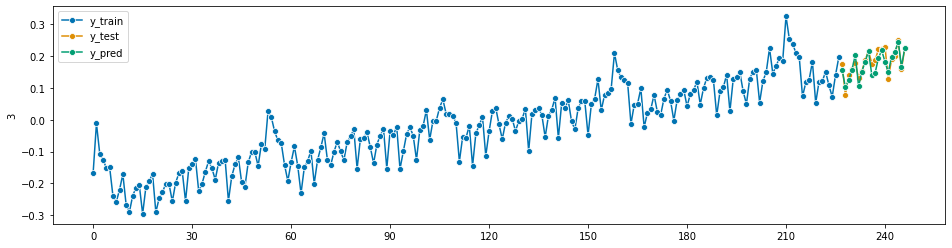

In [24]:
plot_series(train,
            test,
            y_pred, 
            labels=["y_train", "y_test", "y_pred"])

***

## Step 2: Manual Recursive Reduction and Forecasting for Global Model

### Detrend and Deseasonalize the Data

**Return to this later to make sure it is working correctly.**

We need to detrend and deseasonalize the training data. Later, we will apply the inverse transformation to the training data and forecasts, then compare the forecasts to the actual values.

In [25]:
# split into train and test data
Train, Test = Y_t.iloc[:,:-h], Y_t.iloc[:,-h:]

In [26]:
Y_t

,0,1,2,3,4,5,6,7,8,9,...,237,238,239,240,241,242,243,244,245,246
0,0.045797,0.046269,0.046333,0.045894,0.041818,0.039053,0.034914,-0.020333,-0.028005,-0.035947,...,0.020111,0.018691,0.025044,0.027091,0.030902,0.029170,0.028687,0.032130,0.032043,0.031901
1,-0.499713,-0.499713,-0.485901,-0.485901,-0.394271,-0.394271,-0.450197,-0.450197,-0.356558,-0.356558,...,0.218471,0.238889,0.238889,0.257812,0.257812,0.217142,0.217142,0.226352,0.226352,0.204499
2,-0.166215,-0.011674,-0.107066,-0.126658,-0.151466,-0.149855,-0.240029,-0.258843,-0.220123,-0.171545,...,0.186445,0.221556,0.221833,0.228928,0.128260,0.191033,0.201468,0.250905,0.160237,0.224327
3,-0.166215,-0.011674,-0.107066,-0.126658,-0.151466,-0.149855,-0.240029,-0.258843,-0.220123,-0.171545,...,0.186445,0.221556,0.221833,0.228928,0.128260,0.191033,0.201468,0.250905,0.160237,0.224327
4,-0.057376,-0.076016,-0.088321,-0.124195,-0.123208,-0.129639,-0.130632,-0.145647,-0.127656,-0.119271,...,0.100330,0.099541,0.107403,0.112480,0.105051,0.090821,0.102693,0.127558,0.127942,0.097961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,0.011582,0.005151,-0.001321,0.011582,0.005151,-0.001321,0.011582,0.006073,-0.001321,0.010666,...,0.012498,0.005151,-0.001321,-0.007836,-0.014393,0.011582,0.005151,-0.001321,-0.007836,-0.014393
160,0.008700,0.004846,0.000978,-0.002906,-0.006804,0.008700,0.004846,0.000978,-0.002906,0.008700,...,-0.002906,-0.006804,-0.010718,0.008700,0.004846,0.000978,-0.002906,-0.006804,-0.010718,-0.014647
161,-0.127891,-0.127682,-0.112473,-0.108987,-0.074689,-0.081833,-0.087676,-0.093856,-0.096631,-0.095823,...,0.168164,0.171918,0.166300,0.168629,0.162486,0.170565,0.138448,0.087264,0.088483,0.140922
162,-0.239651,-0.286415,-0.284043,-0.305985,-0.248241,-0.355873,-0.193580,-0.324830,-0.242726,-0.160892,...,0.250210,0.270516,0.260459,0.220204,0.202040,0.194966,0.190316,0.189983,0.225176,0.217246


In [27]:
# construct deseasonalizer and detrender
detrender = Detrender(forecaster=PolynomialTrendForecaster(degree=1))
#deseasonalizer = Deseasonalizer(sp=52, model="additive")

In [28]:
detrended_series = [detrender.fit_transform(series) for _ , series in Train.iterrows()]

In [29]:
# detrended_deseasoned_series = [deseasonalizer.fit_transform(series) for series in detrended_series]

In [30]:
Train_transformed = pd.concat(detrended_series, axis=1).T
# Train_transformed = pd.concat(detrended_deseasoned_series, axis=1).T

In [31]:
# full_transformed = pd.concat([Train_transformed, Test], axis=1)

***

### Recursive Reduction for all Series

In [32]:
# slightly modified code from the M4 competition
def reduce_train_test_global(train_data, window_length, h):
    """
    Splits the series into train and test sets.

    Each step takes multiple points as inputs
    :param data: a 2-d numpy array (list) with series as objects (rows)
    :param window_length: window_length
    :param h: number of out of sample points (forecast horizon length)
    :return: reduced train and test datasets
    """
    
    X_train = []
    Y_train = []
    #X_test = []
    #Y_test = []
    #Train, Test = data[:,:-h], data[:,-h:]
    
    for series in train_data:
        train, test = series[:-h], series[-(h + window_length):]
        x_train, y_train = train[:-1], np.roll(train, -window_length)[:-window_length]
        #x_test, y_test = test[:-1], np.roll(test, -window_length)[:-window_length]

        x_train = np.reshape(x_train, (-1, 1))
        temp_train = np.roll(x_train, -1)
        #x_test = np.reshape(x_test, (-1, 1))
        #temp_test = np.roll(x_test, -1)
        
        for x in range(1, window_length):
            x_train = np.concatenate((x_train[:-1], temp_train[:-1]), 1)
            temp_train = np.roll(temp_train, -1)[:-1]
            #x_test = np.concatenate((x_test[:-1], temp_test[:-1]), 1)
            #temp_test = np.roll(temp_test, -1)[:-1]
            
        X_train.append(x_train)
        Y_train.append(y_train)
        #X_test.append(x_test)
        #Y_test.append(y_test)
        
    X_train = np.concatenate(X_train)
    Y_train = np.concatenate(Y_train)
    #X_test = np.concatenate(X_test)
    #Y_test = np.concatenate(Y_test)

    return X_train, Y_train#, X_test, Y_test

In [33]:
X_train, Y_train = reduce_train_test_global(train_data=np.array(Train_transformed),
                                            window_length=window_length,
                                            h=len(fh))

In [34]:
regressor.fit(X_train, Y_train)

LGBMRegressor()

In [35]:
# empty prediction list
global_predictions = []

In [36]:
# select last window of training data
## this is equivalent to the last window of x_train rolled forward to include the last value of y_train
last_window = Train_transformed.iloc[:,-window_length:]

In [37]:
# store forecasted value based on last window of training data
last_prediction = regressor.predict(last_window)

for i in range(len(fh)):
    
    # add latest forecast
    global_predictions.append(last_prediction)

    # roll window forward one period (places first value in window at the end)
    last_window = np.roll(last_window, -1)
    # replace the end value (used to be first value) with the latest forecast
    last_window[:,-1] = last_prediction

    # forecast for next period
    last_prediction = regressor.predict(last_window)

In [38]:
global_predictions = np.concatenate([i.reshape(num_series,1) for i in global_predictions], axis=1)

In [39]:
global_predictions = [pd.Series(i, index=Test.iloc[0,:].index) for i in global_predictions]

***

### Reverse Transformation and Calculate Forecast Accuracy

So now we've generated predictions for all series. We need to reverse the previous transformations (add back in trend and seasonality) and then we can assess accuracy metrics and plot any series.

In [40]:
for i in range(num_series):
    detrender.fit(Train.iloc[i,:])
    global_predictions[i] = detrender.inverse_transform(global_predictions[i])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='100'>)

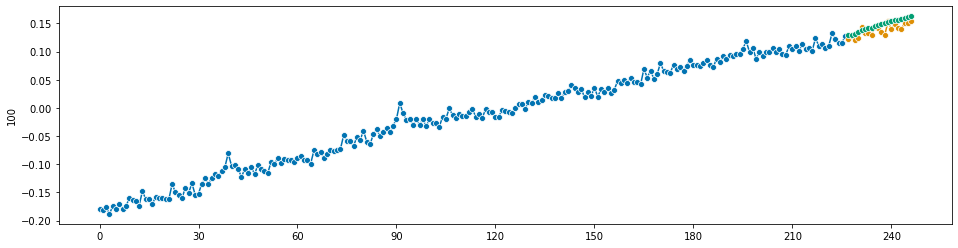

In [41]:
plot_series(Train.iloc[100,:], Test.iloc[100,:], global_predictions[100])

In [42]:
global_predictions = pd.concat(global_predictions, axis=1).T

In [43]:
# expects data passed in (fh, n_outputs) shape
mae_errors = mean_absolute_error(global_predictions.T, Test.T, multioutput='raw_values')

In [44]:
mse_errors = mean_squared_error(global_predictions.T, Test.T, multioutput='raw_values', square_root=True)

In [45]:
# global error
mean_absolute_error(global_predictions.T, Test.T, multioutput='uniform_average')

0.05104653986972371

In [46]:
mean_squared_error(global_predictions.T, Test.T, multioutput='uniform_average', square_root=True)

0.06083499934186932

In [47]:
def nice_plot(series_index, train_vals=Train, test_vals=Test, preds=global_predictions, T=num_periods, h=len(fh)):
    """
    Converts training, testing, and forecasted data for a given series,
    then generates a neat plot from the `sktime` package.

    :param series_index: index of the series to plot
    :param train_vals: training data from all series in shape (num_series, num_training_periods)
    :param test_vals: test data from all series in shape (num_series, forecast_horizon)
    :param preds: forecasted values for each series in shape (num_series, forecast_horizon)
    :param T: total number of time periods in train and test data
    :param h: forecast horizon
    :return: nice `sktime` plot
    """
    y_train = train_vals.iloc[series_index,:]
    y_test = test_vals.iloc[series_index,:]
    y_pred = preds.iloc[series_index,:]
    
    plot_series(y_train,
                y_test,
                y_pred, 
                labels=["y_train", "y_test", "y_pred"])

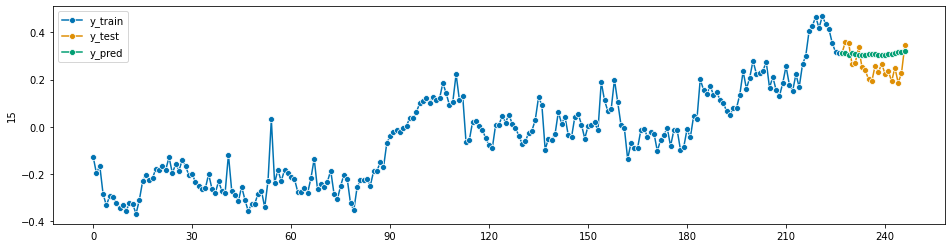

In [48]:
nice_plot(15)

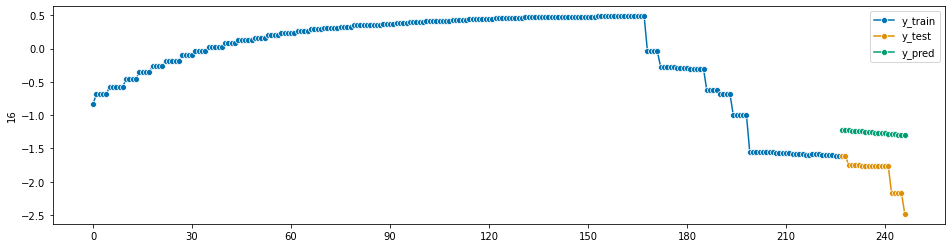

In [49]:
nice_plot(16)

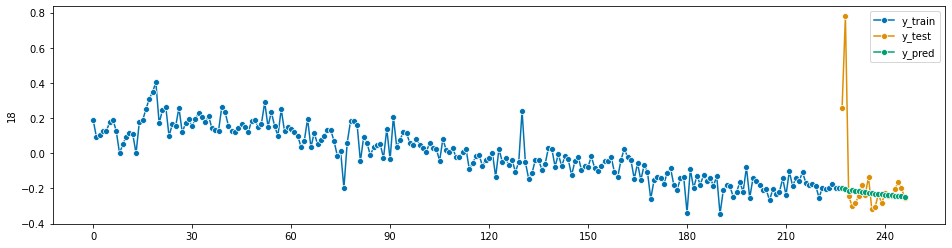

In [50]:
nice_plot(18)

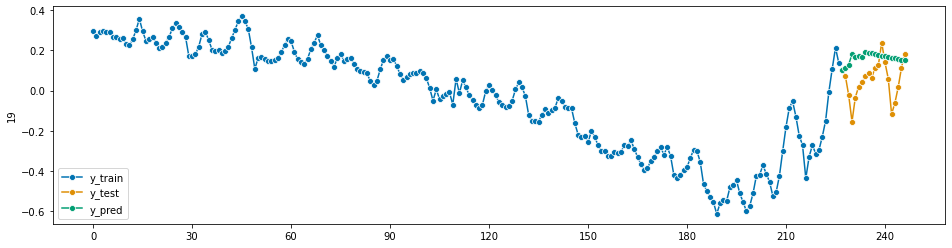

In [51]:
nice_plot(19)

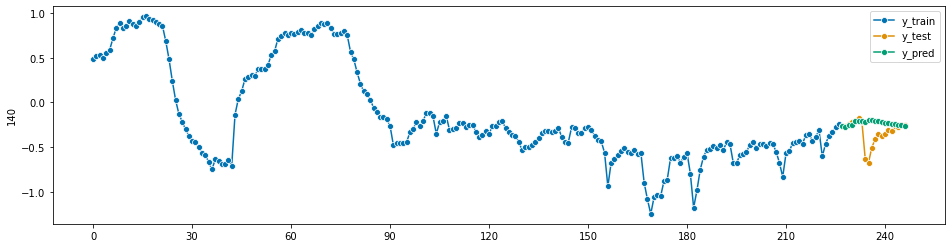

In [52]:
nice_plot(140)

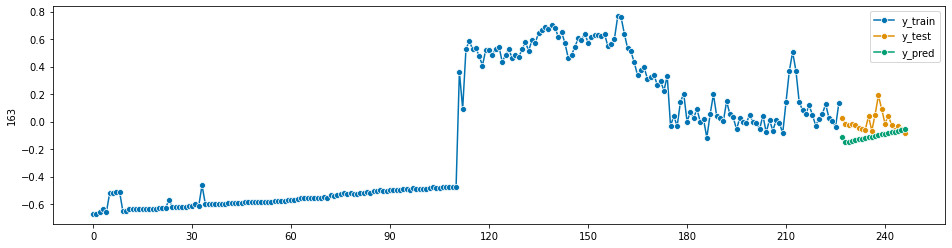

In [53]:
nice_plot(163)

***